## Object detection labeling

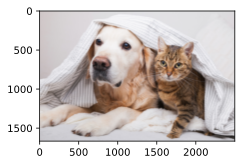

In [12]:
%matplotlib inline
import torch
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.plt.imread('../img/catdog.jpg')
d2l.plt.imshow(img);

In [18]:
def box_corner_to_center(boxes):
    """
    (left_top, right_bottom) => (center, width, height)
    boxes: num_objects*4
    """
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1 # note: the bottom one y2 > y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [23]:
dog_bbox, cat_bbox = [500.0, 100.0, 1500.0, 1500.0], [1520.0, 300.0, 2200.0, 1600.0]
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [24]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

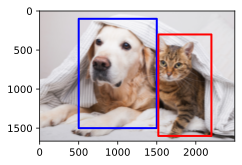

In [25]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

## Objecte detection dataset

In [26]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip', '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [27]:
def read_data_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Here `target` contains (class, upper-left x, upper-left y,
        # lower-right x, lower-right y), where all the images have the same
        # banana class (index 0)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [28]:
class BananasDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [29]:
def load_data_bananas(batch_size):
    """Load the banana detection dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [30]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

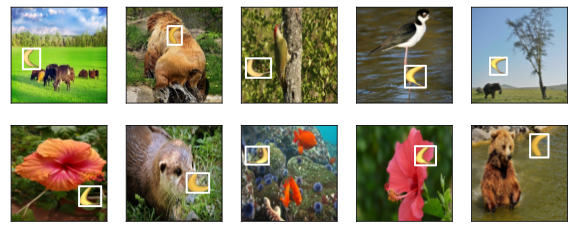

In [31]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])